In [1]:
import os
os.chdir("../../")

In [2]:
import scanpy as sc
from sklearn.preprocessing import LabelEncoder
from scvi.dataset import AnnDatasetFromAnnData
from _scVI import scVI_Trainer, ADataset
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scvi.models.vae import VAE
import numpy as np
import surgeon

[2019-12-20 16:46:55,653] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/mohsen/.local/lib/python3.6/site-packages/scikit_learn-0.21.3-py3.6-linux-x86_64.egg/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)
Using TensorFlow backend.
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mohsen/miniconda3/envs/venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (ty

In [3]:
sc.settings.set_figure_params(dpi=200)

In [4]:
condition_key = 'study'
cell_type_key = 'cell_type'
target_conditions = ["Tabula_muris", "Zeisel"]

In [5]:
adata = sc.read("data/mouse_brain/mouse_brain_normalized.h5ad")
adata = adata[adata.obs[condition_key].isin(target_conditions)]
adata

View of AnnData object with n_obs × n_vars = 15250 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

In [6]:
adata.X = adata.raw.X.A

In [7]:
adata.X.min(), adata.X.max()

(0.0, 824247.0)

In [8]:
adata.obs.groupby([condition_key, cell_type_key]).size()

study         cell_type                     
Tabula_muris  astrocyte                          472
              brain pericyte                     156
              endothelial cell                   715
              macrophage                          61
              microglial cell                   4394
              neuron                             281
              oligodendrocyte                   1574
              oligodendrocyte precursor cell     203
Zeisel        astrocyte                         1059
              brain pericyte                     281
              endothelial cell                   392
              ependymal cell                      79
              macrophage                          96
              microglial cell                    275
              neuron                            3584
              olfactory ensheathing cell         107
              oligodendrocyte                   1485
              oligodendrocyte precursor cell      36
d

In [9]:
adata.obs['labels'] = LabelEncoder().fit_transform(adata.obs[cell_type_key])
adata.obs['batch_indices'] = LabelEncoder().fit_transform(adata.obs[condition_key])

In [10]:
adata.obs['labels'].value_counts()

5    4669
6    3865
8    3059
0    1531
2    1107
1     437
9     239
4     157
7     107
3      79
Name: labels, dtype: int64

In [11]:
adata.obs['batch_indices'].value_counts()

0    7856
1    7394
Name: batch_indices, dtype: int64

In [12]:
scvi_adata = ADataset(adata)
scvi_adata

[2019-12-20 16:46:57,681] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-12-20 16:46:57,682] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-12-20 16:46:57,705] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-12-20 16:46:57,728] INFO - scvi.dataset.dataset | Downsampled from 15250 to 15250 cells


GeneExpressionDataset object with n_cells x nb_genes = 15250 x 2000
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'labels', 'local_vars', 'batch_indices', 'local_means'
    cell_categorical_attribute_names: 'labels', 'batch_indices'

In [13]:
scvi_adata.n_labels, scvi_adata.n_batches, scvi_adata.nb_genes

(10, 2, 2000)

In [14]:
np.unique(scvi_adata.batch_indices)

array([0, 1], dtype=uint16)

In [15]:
np.unique(scvi_adata.labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint16)

## Creating the Model

In [16]:
n_epochs = 1000
lr = 1e-3
early_stopping_kwargs = {
    "early_stopping_metric": "elbo",
    "save_best_state_metric": "elbo",
    "patience": 50,
    "threshold": 0,
    "reduce_lr_on_plateau": True,
    "lr_patience": 40,
    "lr_factor": 0.1,
}
use_batches = True
n_samples = adata.shape[0]

In [17]:
vae = VAE(scvi_adata.nb_genes, n_batch=scvi_adata.n_batches * use_batches)

In [18]:
trainer = scVI_Trainer(
    vae,
    scvi_adata,
    train_size=0.8,
    use_cuda=True,
    frequency=1,
    early_stopping_kwargs=early_stopping_kwargs,
)

In [19]:
trainer.train(None, n_epochs=n_epochs, lr=lr)

training:  22%|██▏       | 215/1000 [03:38<13:27,  1.03s/it]

[2019-12-20 16:50:39,839] INFO - scvi.inference.trainer | Reducing LR.
INFO:scvi.inference.trainer:Reducing LR.


training:  22%|██▎       | 225/1000 [03:48<13:01,  1.01s/it]

[2019-12-20 16:50:49,915] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 50 epochs
INFO:scvi.inference.trainer:
Stopping early: no improvement of more than 0 nats in 50 epochs
[2019-12-20 16:50:49,916] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
INFO:scvi.inference.trainer:If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


training:  23%|██▎       | 226/1000 [03:49<13:07,  1.02s/it]


In [20]:
trainer.train_set.reconstruction_error()

1104.589353227459

In [21]:
trainer.history.keys()

dict_keys(['elbo_train_set', 'elbo_test_set'])

In [22]:
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]

/home/mohsen/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


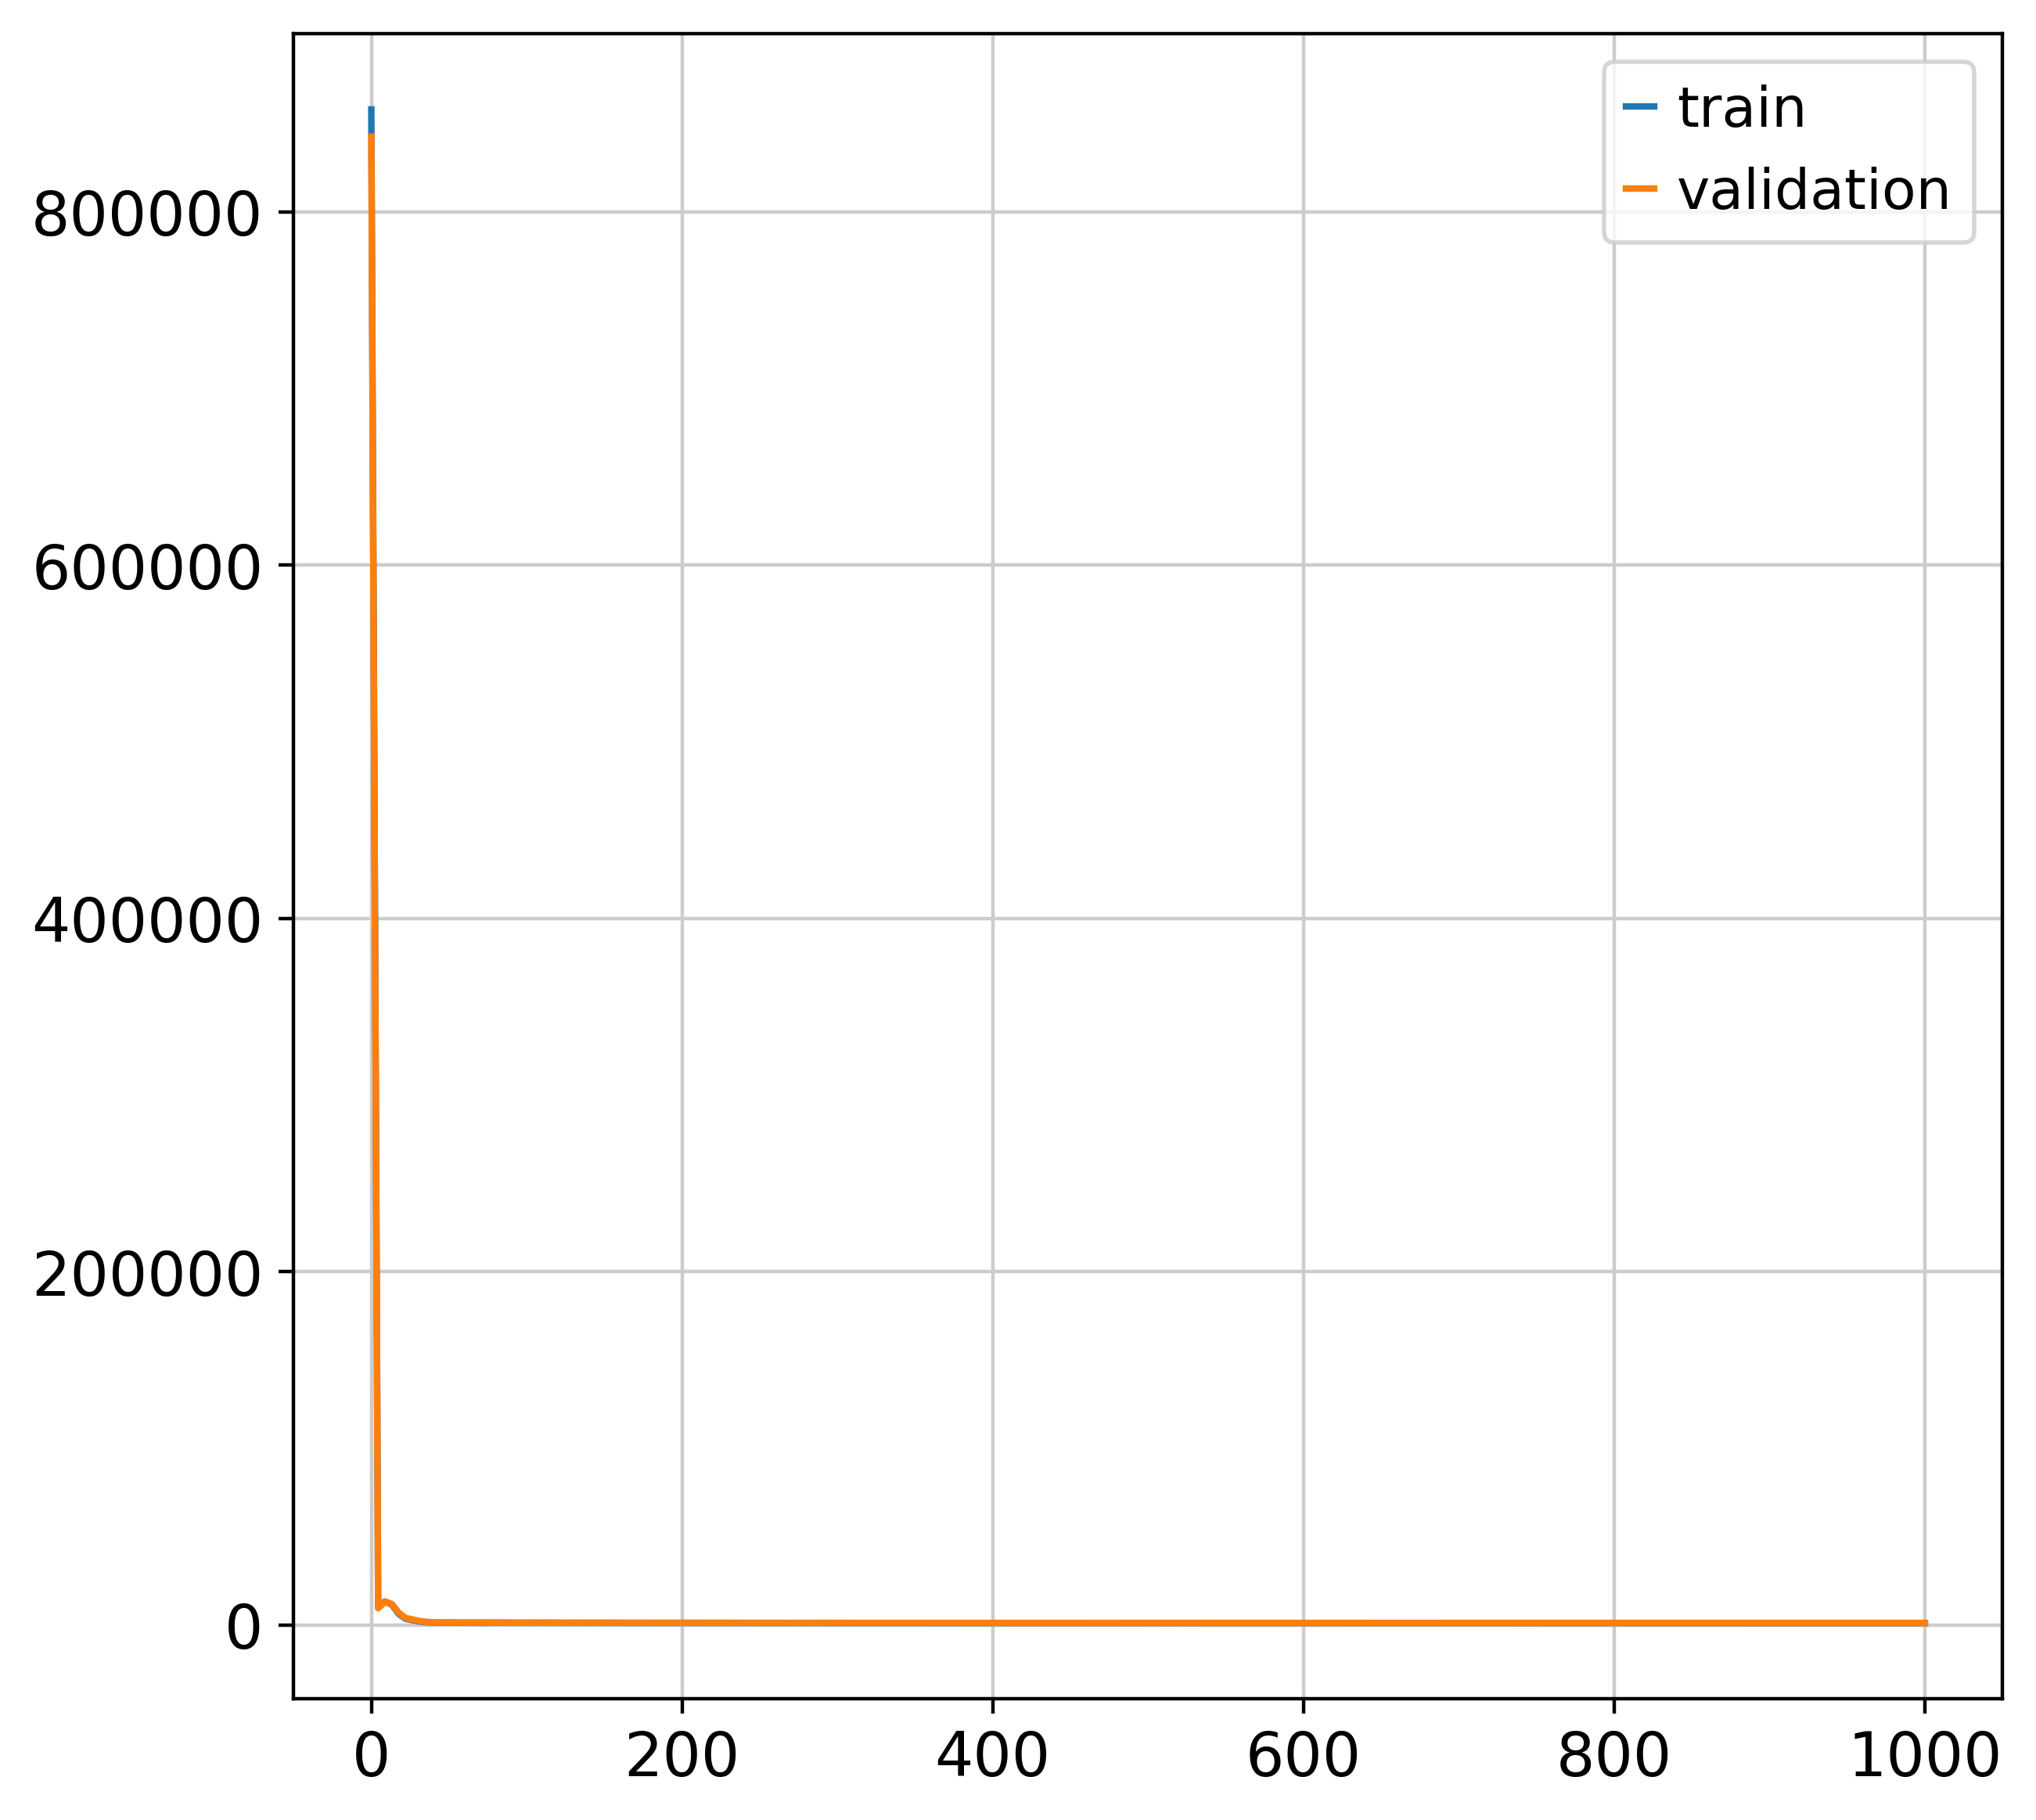

In [23]:
x = np.linspace(0, 1000, (len(elbo_train_set)))
plt.close("all")
plt.figure(figsize=(7, 7))
plt.plot(x, elbo_train_set, label='train')
plt.plot(x, elbo_test_set, label='validation')
plt.legend()
plt.show()

In [24]:
le = LabelEncoder()
le.fit(target_conditions)
le.classes_

array(['Tabula_muris', 'Zeisel'], dtype='<U12')

In [25]:
posterior = trainer.create_posterior(vae, scvi_adata, indices=np.arange(len(scvi_adata)))

In [26]:
latent, batch_ind, labels = posterior.get_latent()

In [27]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [28]:
np.unique(batch_ind)

array([0, 1])

In [29]:
import pandas as pd

In [30]:
latent_adata = sc.AnnData(X=latent)
latent_adata.obs[cell_type_key] = pd.Categorical(labels)
latent_adata.obs[condition_key] = pd.Categorical(batch_ind[:, 0])
latent_adata

AnnData object with n_obs × n_vars = 15250 × 10 
    obs: 'cell_type', 'study'

In [31]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

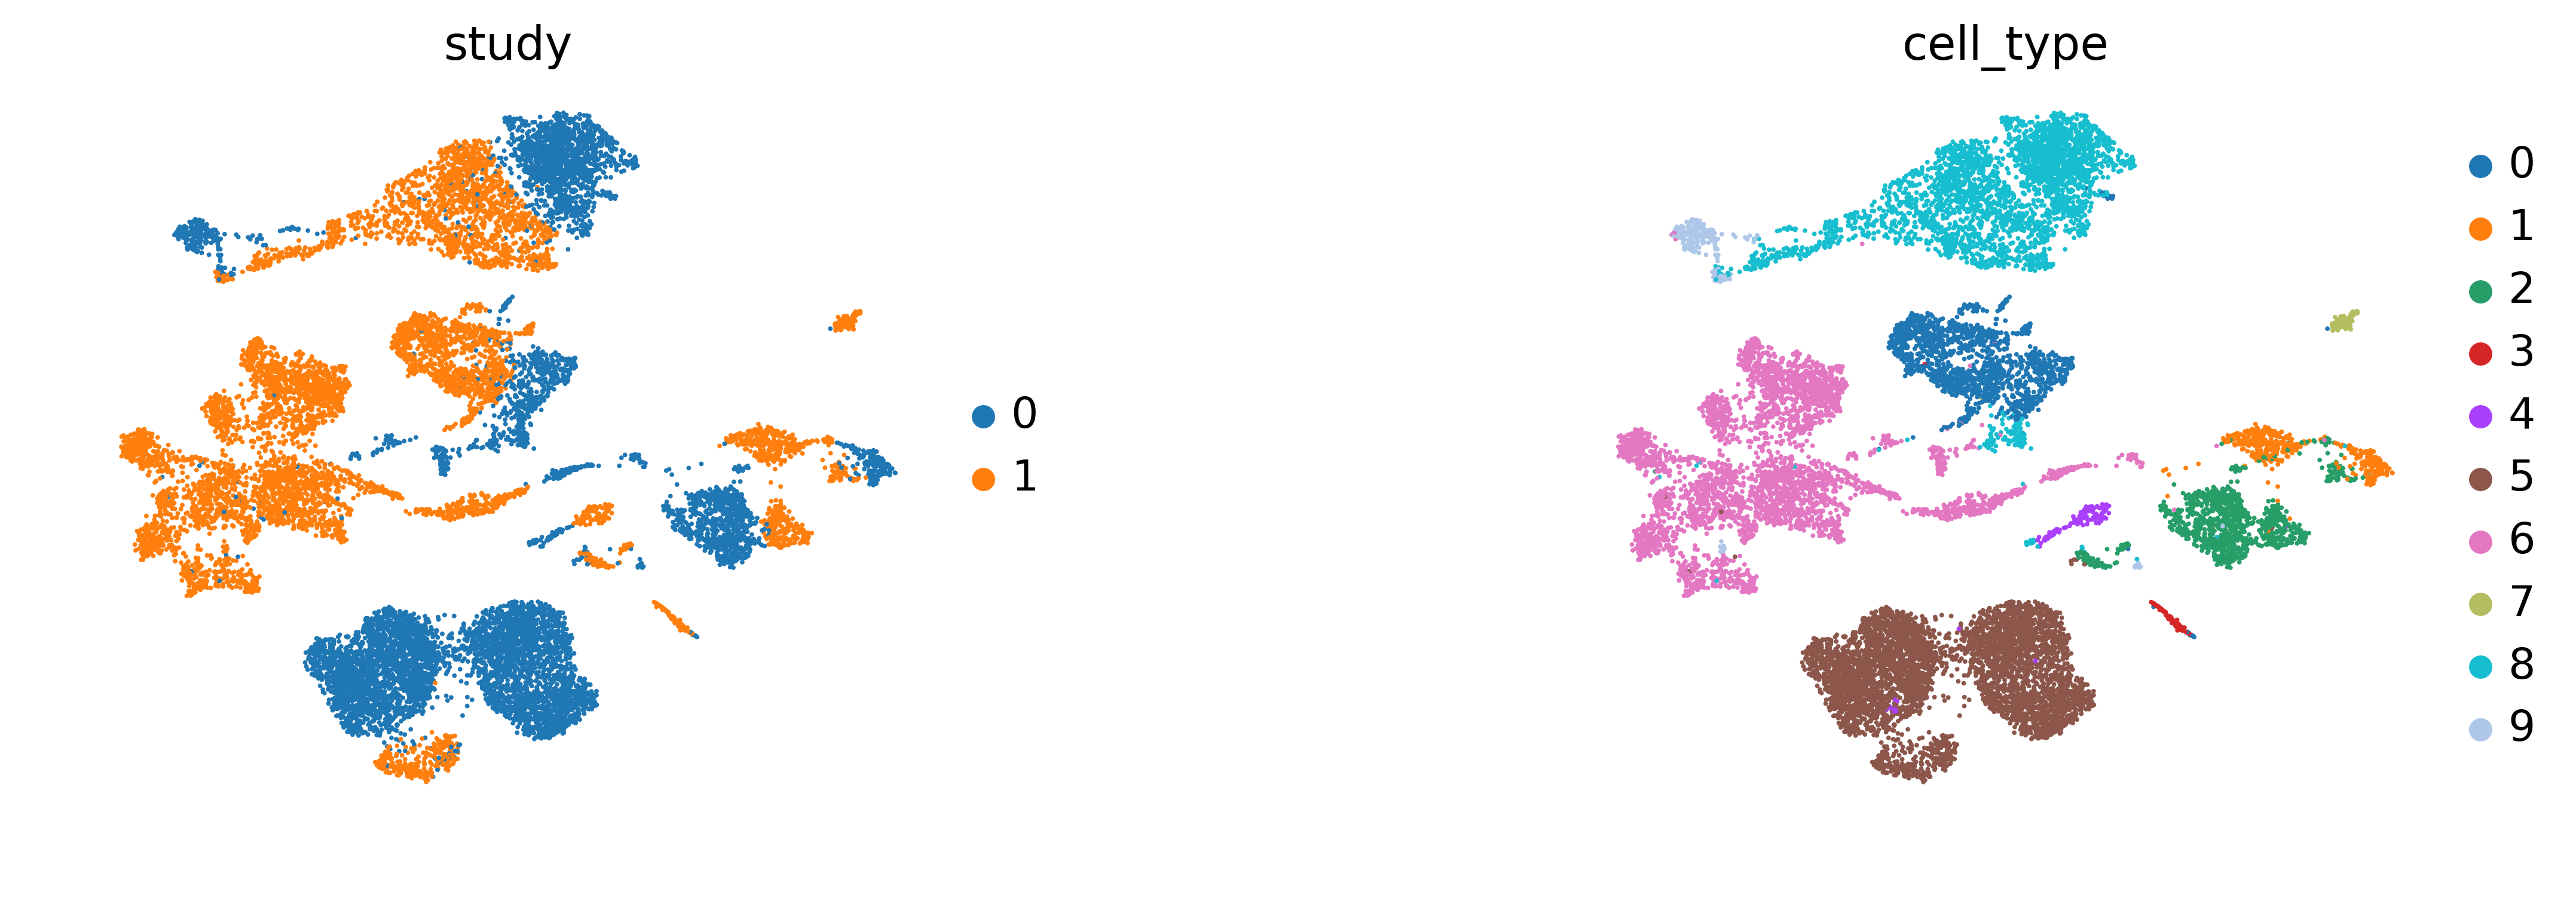

In [32]:
sc.pl.umap(latent_adata, color=[condition_key, cell_type_key], 
           frameon=False, wspace=0.6, show=True)

In [33]:
surgeon.metrics.knn_purity(latent_adata, label_key=cell_type_key, n_neighbors=15)

0.9699096736316918

In [34]:
surgeon.metrics.entropy_batch_mixing(latent_adata, label_key=cell_type_key, n_neighbors=15)

0.02072838005256307